In [2]:
import csv
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 15]
from tqdm import tqdm_notebook
import random
import numpy as np

In [3]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
def stem(points, stemmer):
    print("Stemming words")
    for i in tqdm_notebook(range(len(points))):
        sentence = points[i].decode("utf8")
        words = word_tokenize(sentence)
        new_point = ""
        for word in words:
            new_point += stemmer.stem(word) + " "
        points[i] = new_point
    return points

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
def to_bag_of_words(points, stemmer):
    if stemmer:
        points = stem(points, stemmer)
    vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
    vectors = vectorizer.fit_transform(points).toarray()
    N = len(vectorizer.vocabulary_)
    return vectors, N

In [6]:
def read_points(stemmer):
    points = []
    labels = []
    with open ('../Datasets/smsspam.csv', 'r') as fin:
        csvReader = csv.reader(fin, delimiter=',')
        for row in csvReader:
            if csvReader.line_num != 1:
                points.append((row[1]))
                labels.append(row[0])
    points, N = to_bag_of_words(points, stemmer)
    return points, labels, N

In [7]:
def split(points, labels):
    test_indexes = random.sample(range(len(points)), len(points) // 5)
    train_indexes = set([i for i in range(len(points))]) - set(test_indexes)
    return [points[i] for i in train_indexes], [labels[i] for i in train_indexes], [points[i] for i in test_indexes], [labels[i] for i in test_indexes]

In [8]:
def bayesian_classifier(train_points, train_labels, unique_labels):
    def count(i, point, points):
        cnt = 0
        for p in points:
            if p[i] == point[i]:
                cnt += 1
        return cnt
    
    label_point_prob = []
    label_prob = []
    
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        label_points = []
        for j in range(len(train_points)):
            if train_labels[j] == label:
                label_points.append(train_points[j])
        label_prob.append(len(label_points) * 1.0 / len(train_points))
        label_point_prob.append([])
        label_points = np.array(label_points)
        print("Calculating probabilities for label " + unique_labels[i])
        for j in tqdm_notebook(range(len(train_points[0]))):
            label_point_prob[i].append([])
            label_point_prob[i][j] = {}
            minn = label_points[:,j].min()
            maxx = label_points[:,j].max()
            for k in range(minn, maxx + 1):
                label_point_prob[i][j][k] = 0
            for point in label_points:
                label_point_prob[i][j][point[j]] += 1
            for k in range(minn, maxx + 1):
                label_point_prob[i][j][k] =  label_point_prob[i][j][k] * 1.0 / len(label_points)
    return label_prob, label_point_prob
    

In [9]:
def roc(points, labels, true_label, scores, true_label_scores):
    x = [0]
    y = [0]
    for j in range(len(true_label_scores)):
        true_score = true_label_scores[j]
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(scores)):
            if scores[i] >= true_score:
                if labels[i] == true_label:
                    tp += 1
                else:
                    fp += 1
            else:
                if labels[i] == true_label:
                    fn += 1
                else:
                    tn += 1
        if tp + fn != 0:
            y.append(tp * 1.0 / (tp + fn))
        else:
            y.append(0)
        if fp + tn != 0:
            x.append(fp * 1.0 / (fp + tn))
        else:
            x.append(0)
    return x, y

In [10]:
import math
def bayess_predict(label_prob, label_point_prob, point, unique_labels, alpha, N):
    max_score = None
    max_label = None
    scores = []
    for i in range(len(unique_labels)):
        score = np.log(label_prob[i] + alpha * N)
        for j in range(len(point)):
            score += np.log(label_point_prob[i][j].get(point[j], 0) + alpha)
        scores.append(score)
        if not max_score or score > max_score:
            max_score = score
            max_label = unique_labels[i]
    other_score = 0
    if max_score == scores[0]:
        other_score = scores[1]
    else:
        other_score = scores[0]
    result = 1.0 / (np.exp(other_score - max_score))
    if not math.isnan(result):
        return result, max_label
    return 0.5, max_label    

In [11]:
def test_bayesian_classifier(alpha, stemmer=None):
    true_label = 'spam'
    points, labels, N = read_points(stemmer)
    unique_labels = np.unique(np.array(labels)).tolist()
    train_points, train_labels, test_points, test_labels = split(points, labels)
    label_prob, label_point_prob = bayesian_classifier(train_points, train_labels, unique_labels)
    scores = []
    is_true = []
    accuracy = 0
    print("Testing")
    for i in tqdm_notebook(range(len(test_points))):
        point = test_points[i]
        score, label = bayess_predict(label_prob, label_point_prob, point, unique_labels, alpha, N)
        is_true.append(label == true_label)
        scores.append(score)
        if (test_labels[i] == label):
            accuracy += 1
    print("Accuracy = " + str(accuracy * 1.0 / len(test_points)))
        
    for i in range(len(test_points)):
        if not is_true[i]:
            scores[i] = 1 - scores[i]
    true_label_scores = list(scores)
    true_label_scores = sorted(set(true_label_scores), reverse=True)
    x, y = roc(test_points, test_labels, true_label, scores, true_label_scores)
    plt.plot(x, y)
    plt.show()

Stemming words



Calculating probabilities for label ham



Calculating probabilities for label spam



Testing



Accuracy = 0.868940754039


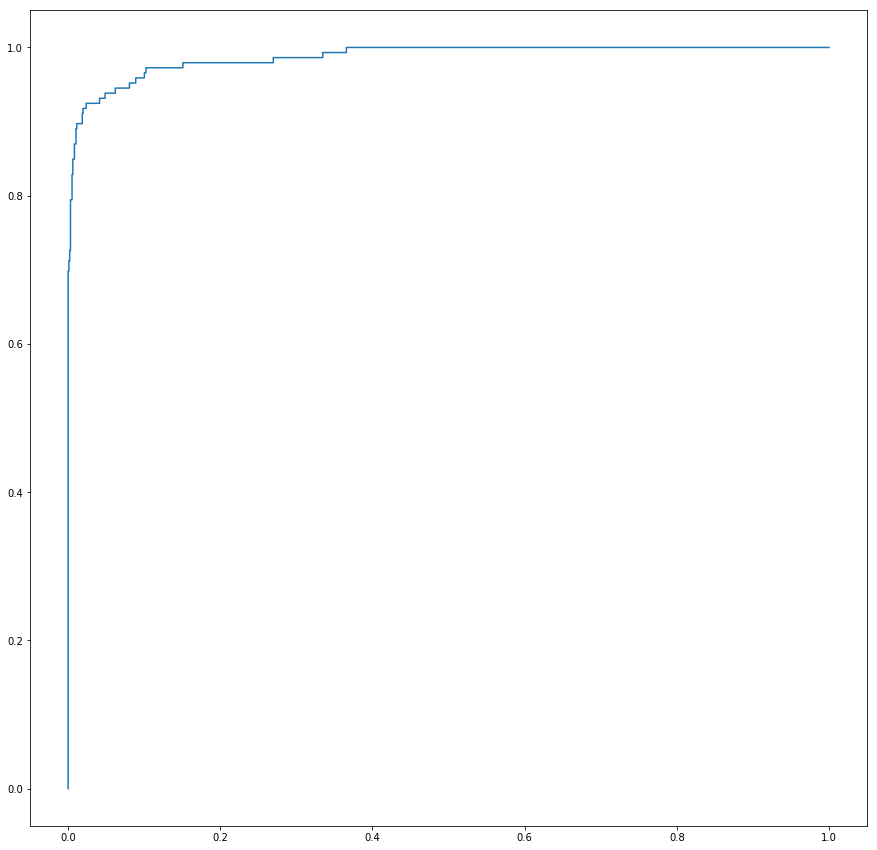

In [12]:
from nltk.stem import PorterStemmer
test_bayesian_classifier(1, PorterStemmer())

Stemming words



Calculating probabilities for label ham



Calculating probabilities for label spam



Testing



Accuracy = 0.865350089767


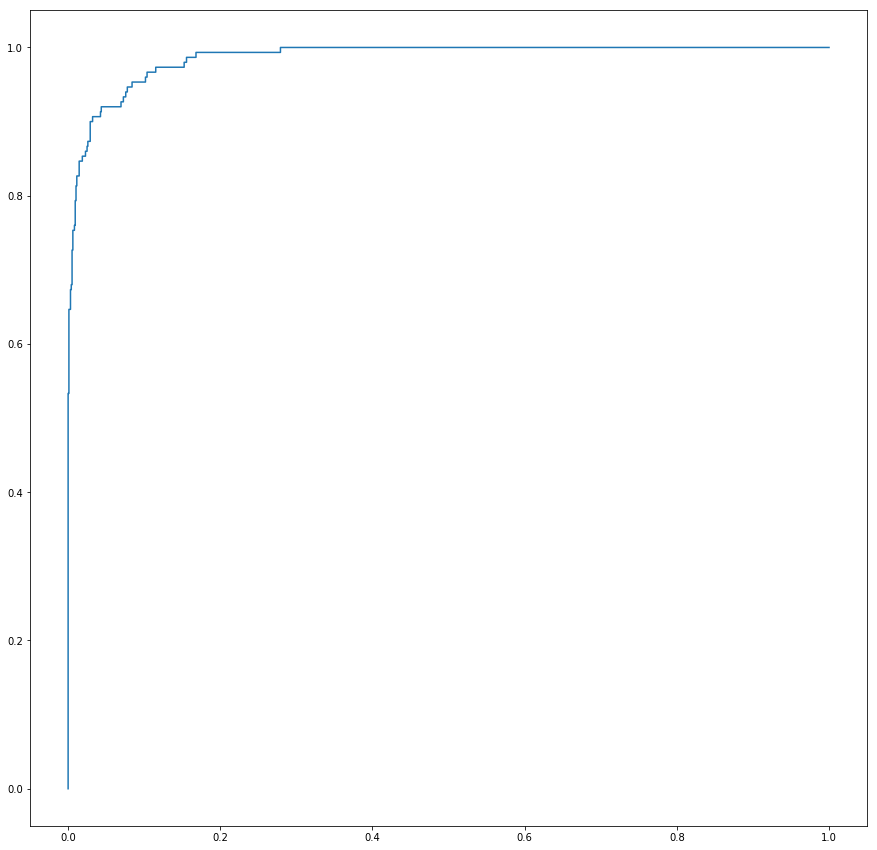

In [13]:
from nltk.stem import LancasterStemmer
test_bayesian_classifier(1, LancasterStemmer())

Stemming words



Calculating probabilities for label ham



Calculating probabilities for label spam



Testing



Accuracy = 0.868043087971


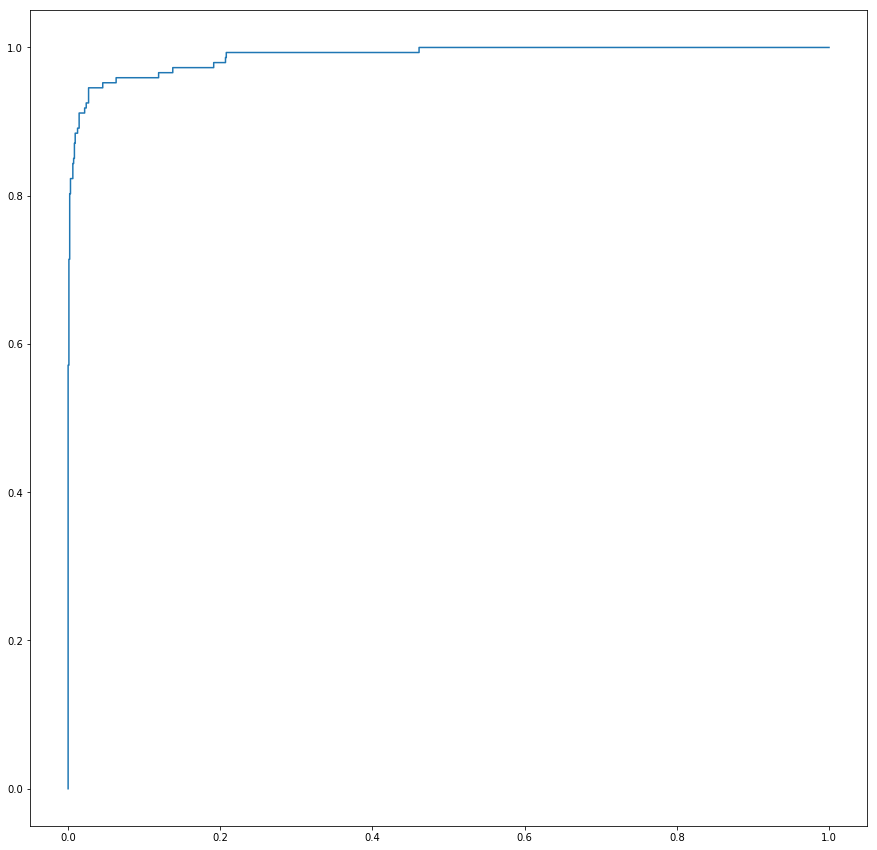

In [14]:
from nltk.stem import SnowballStemmer
test_bayesian_classifier(1, SnowballStemmer('english', ignore_stopwords=True))

Calculating probabilities for label ham



Calculating probabilities for label spam



Testing



Accuracy = 0.868940754039


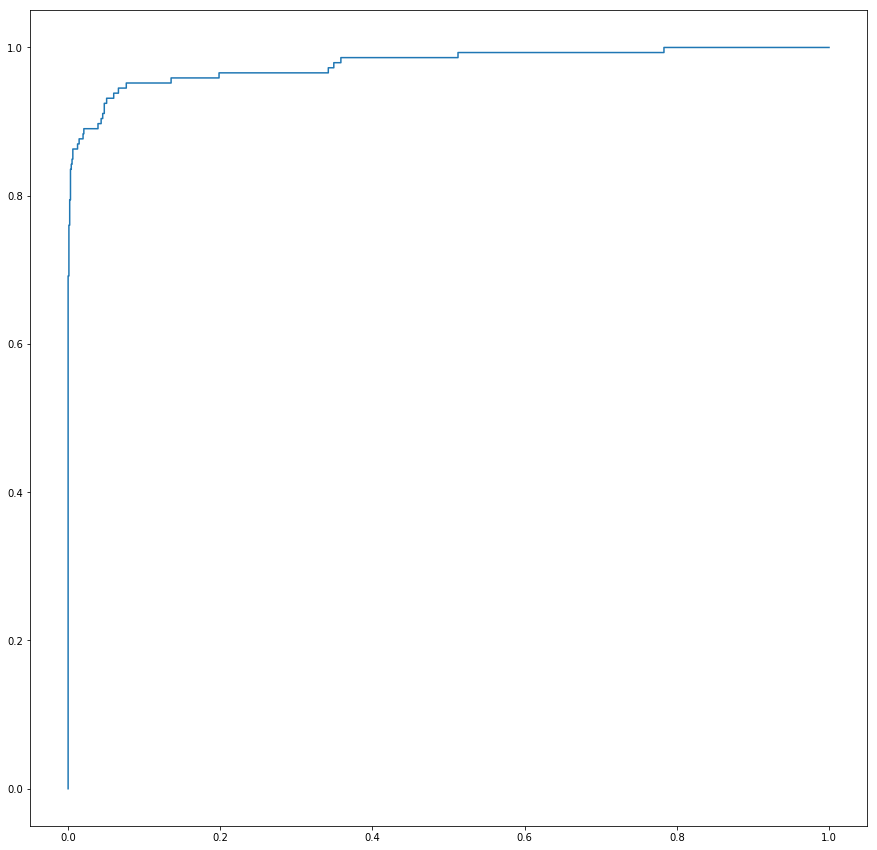

In [15]:
test_bayesian_classifier(1)